In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "../../../data/dogsbreeds/"
sz=224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['test', 'models', 'train', 'labels.csv', 'tmp']

In [8]:
os.listdir(f'{PATH}train')

['861dee51881dc7a69672f63d5370f4a7.jpg',
 '032620ae0f847d957d94d1fd76cb17e8.jpg',
 ...]

In [9]:
files = os.listdir(f'{PATH}train')[:5]
files

['861dee51881dc7a69672f63d5370f4a7.jpg',
 '6fd91d9b93604a4b156662fb1d763d29.jpg',
 '6f8095672995666a0d6dd4e7daadecde.jpg',
 '79cfdadcf7d192139150d23f49041aa7.jpg',
 '12b880c67ff773988a16cee76be47c54.jpg']

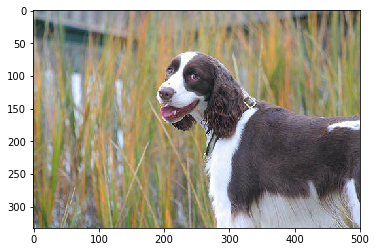

In [10]:
img = plt.imread(f'{PATH}train/{files[1]}')
plt.imshow(img);

In [11]:
img.shape

(333, 500, 3)

In [12]:
img[:4,:4]

array([[[162, 164, 176],
        [162, 166, 177],
        [160, 166, 178],
        [156, 164, 177]],

       [[166, 169, 178],
        [166, 170, 181],
        [164, 170, 182],
        [159, 167, 180]],

       [[171, 171, 181],
        [170, 173, 182],
        [168, 172, 183],
        [161, 167, 179]],

       [[173, 172, 180],
        [173, 173, 183],
        [169, 172, 181],
        [163, 167, 178]]], dtype=uint8)

In [13]:
labels_csv = f'{PATH}labels.csv'
n = len(list(open(labels_csv)))-1
val_idxs = get_cv_idxs(n)

In [14]:
n

10222

In [15]:
len(val_idxs)

2044

### Initial model

In [16]:
arch=resnet50
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=64)

In [17]:
!nvidia-smi

Sun Oct 21 09:47:54 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 23%   32C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 23%   33C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [18]:
print(torch.cuda.device_count())
#print(torch.cuda.set_device(1))
print(torch.cuda.current_device())

8
0


In [19]:
torch.cuda.set_device(0)

In [20]:
torch.cuda.current_device()

0

In [21]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

### Finding the learning rate

In [22]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                   
    0      1.32427    0.626699   0.844423  
    1      0.662492   0.478176   0.863014                    
    2      0.483892   0.442955   0.869374                    
    3      0.393163   0.423827   0.870352                    
    4      0.340667   0.419203   0.869863                    



[0.4192030219590827, 0.8698630155649204]

In [23]:
# !wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

In [24]:
# !tar xvfz fastai/weights.tgz -C fastai

### Initial model, but arch = resnext101_64

In [25]:
arch = resnext101_64
# tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
#                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=64)

In [26]:
bs=58
sz=180

In [27]:

def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

data = get_data(sz, bs)

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                   
    0      1.043934   0.501651   0.87182   
    1      0.551552   0.415479   0.872798                    
    2      0.372063   0.396314   0.883562                    
    3      0.301763   0.386693   0.885029                    
    4      0.26387    0.372263   0.887476                    



[0.3722626813660046, 0.8874755437593405]

### Augment

In [29]:
# cycle_len = 1. This enables stochastic gradient descent with restarts (SGDR).

In [30]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.206745   0.369557   0.894814  
    1      0.191031   0.370326   0.892857                    
    2      0.163326   0.370256   0.892857                     
    3      0.162542   0.371997   0.891879                    
    4      0.142658   0.369708   0.893836                    



[0.3697082408778588, 0.8938356212207249]

In [31]:
learn.precompute = False

In [32]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.295752   0.375187   0.891879  
    1      0.271819   0.366281   0.892857                    
    2      0.260376   0.362722   0.896282                    
    3      0.253457   0.36925    0.894814                    
    4      0.236971   0.372987   0.892857                    



[0.3729870142269362, 0.8928571403493153]

In [33]:
learn.save('180_pre')

In [34]:
learn.load('180_pre')

### Increase size

In [35]:
learn.set_data(get_data(299, bs)) 
learn.freeze()

In [36]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [37]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.23394    0.24075    0.924658  
    1      0.219544   0.234125   0.926614                    
    2      0.1911     0.232627   0.928571                    



[0.23262660285920897, 0.9285714274633188]

In [38]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.181113   0.232942   0.926614  
    1      0.180881   0.239736   0.923679                    
    2      0.155669   0.230068   0.926614                    
    3      0.155184   0.236099   0.928082                    
    4      0.146628   0.228495   0.926614                    
    5      0.132695   0.228395   0.92955                     
    6      0.129075   0.228071   0.928082                    



[0.2280709246764007, 0.9280821963299044]

Validation loss is so much greater than training loss. This implies overfitting. We'll leave out cycle_mult=2. 

In [39]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9368884540117417, 0.21782801558437495)

In [40]:
learn.save('299_pre')

In [41]:
learn.load('299_pre')

In [42]:
learn.fit(1e-2, 1, cycle_len=2) # 1+1 = 2 epochs

epoch      trn_loss   val_loss   accuracy                    
    0      0.126433   0.233255   0.922701  
    1      0.120007   0.22951    0.927104                    



[0.22951042452196493, 0.9271037205324714]

In [43]:
learn.save('299_pre')

In [44]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9315068493150684, 0.22299923877443537)

This dataset is so similar to ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze.

### Individual Prediction

In [45]:
fn = data.val_ds.fnames[0]
fn

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

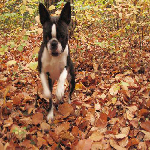

In [46]:
Image.open(PATH + fn).resize((150, 150))

In [47]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

19

In [48]:
learn.data.classes[np.argmax(preds)]

'boston_bull'

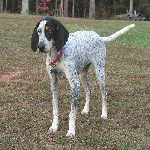

In [50]:
fn = data.val_ds.fnames[1]
Image.open(PATH + fn).resize((150, 150))

In [51]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)
learn.data.classes[np.argmax(preds)]

'bluetick'

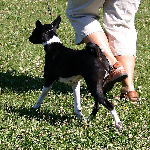

In [52]:
fn = data.val_ds.fnames[2]
Image.open(PATH + fn).resize((150, 150))

In [53]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)
learn.data.classes[np.argmax(preds)]

'basenji'

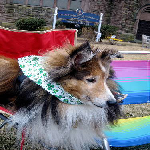

In [54]:
fn = data.val_ds.fnames[3]
Image.open(PATH + fn).resize((150, 150))

In [55]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)
learn.data.classes[np.argmax(preds)]

'shetland_sheepdog'

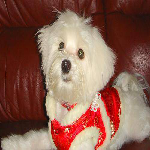

In [56]:
fn = data.val_ds.fnames[4]
Image.open(PATH + fn).resize((150, 150))

In [57]:
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)
learn.data.classes[np.argmax(preds)]

'maltese_dog'